In [64]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from scipy.stats.distributions import chi2
from scipy.sparse import coo_matrix
from scipy.sparse import linalg
from numpy.random import default_rng
import moments
import itertools as it

# plotting + misc tools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *
import os
from copy import copy

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis of complex demographic scenarios from PReFerSim

In this file, I will simulate changing population sizes and increase the level of complexity with each simulation. 

1. Bottleneck.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, 20k inds 10k gens ago, followed by 2k inds 2k gens ago)
`(https://github.com/dortegadelv/HaplotypeDFEStandingVariation/blob/master/Scripts/Sims/AncientBottleneck/ForwardSims/ParameterFile_4Ns-50.txt)`

In [3]:
## Need to create look-up tables matching the above demographic history...also run the gamma search over a relevant grid
gamma = -np.geomspace(1e-5,5e-3,20) #np.logspace(-0.5,2.5,25)
n = 1000
N = 10000
mu = 1.25e-8
cutoff = 2 # freq of 0.5%
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
# for N=10,000 & gamma=-10, s=-0.0005

In [3]:
# s = -np.array([8e-5]) # gamma of 2, 20, 200 for N=10,000 & 4Ns
# for ig, g in enumerate(s):
#     with open('simfiles/ParameterFilesBottleneck.txt',"r") as file:
#         data = file.readlines()

#     data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-g)
#     data[7] = 'FilePrefix: outfiles/Bottleneck{:.0e}\n'.format(-g)

#     with open('simfiles/ParameterFilesBottleneck.txt', 'w') as file:
#         file.writelines(data)
        
#     os.system("GSL_RNG_SEED=1004 GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesBottleneck.txt 1")

In [138]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/Bottleneck3e-03.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=1200)
Nc = np.concatenate((np.repeat(20000,80000),np.repeat(2000,2000)))
nu_func = lambda t: [Nc[int(t*Nc[0])]/Nc[0]]
df1
df1['sXl'] = df1['Xl']*n #rng.binomial(n=n, p=df1['Xl'])
df1['al'] = len(Nc)+1 - df1['al']
dat = df1.to_numpy(dtype='int64')
# plt.hist(df1['sXl'],50); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
# plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

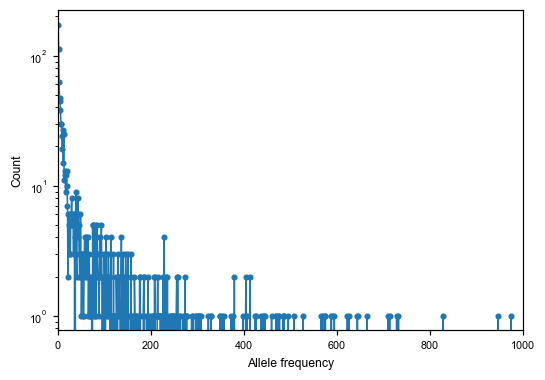

In [272]:
# counts, bins, _ = plt.hist(df1['sXl'],bins=2000,range=(0.5,2000.5))
fsbot = moments.Spectrum(np.histogram(df1['sXl'],bins=np.arange(0,n+2))[0],mask_corners=False)
moments.Plotting.plot_1d_fs(fsbot)

In [274]:
fs = moments.Spectrum(np.zeros(3*n+1))
fs[1] = 1
fs.integrate(nu_func, 4.002,gamma=gamma[-1]*2*N,dt_fac=0.0005,theta=10)
fs.project([n])*3
np.sum(fs<0)
# plt.plot(np.linspace(0.5/N,4.09)*2*N,N*np.array([nu_func(x) for x in np.linspace(4.09,0.5/N)])); plt.semilogx()
# plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
# plt.plot(Nc[::-1]/Nc[0]); plt.semilogx()

N_old,  [1.000] N_new [0.100]
relative change 0.9


6

In [106]:
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# # moments.Inference.ll_multinom(fs,fsbot)
# # np.sum(-fs + fsbot*np.log(fs) - sp.special.gammaln(fsbot+1))
# moments.Inference.ll(fsbot.S()/fs.S()*fs,fsbot)

In [ ]:
## creating a log-likelihood function that actually captures the true value using Poisson dist
# def get_lp_xl(model, g, dat, n=2000, cutoff=20):
#     """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
#     res = np.empty(np.sum((sXlred>=cutoff) & (sXlred<=n-cutoff+1))) #np.empty(len(Xlred))

#     # just performing a search in a look-up table
#     for idx, i in enumerate(np.where((sXlred>=cutoff) & (sXlred<=n-cutoff+1))[0]):
#         res[idx] = p_xa_s[g][sXlred[i]]
    
#     return np.log(res)

-0.005

In [129]:
## creating a database of P(X, a | s) with dicts for different s values
del up_xa_s
up_xa_s = {}
for ig, g in enumerate(gamma):
    ## unscaled probability - almost likelihood # original options: n, g, 2*Nc[::-1], ...
    up_xa_s[g] = run_mom_iterate_changing(n, 2*g, Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
    # up_xa_s[g] = run_mom_iterate_constant(20000, 2000, 0.5*g/Nc[0], N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

del p_xa_s
p_xa_s = {}
for g in gamma:
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    fs = moments.Spectrum(np.zeros(n+1))
    fs[1] = 1
    fs.integrate(nu_func, 4.05, gamma=g*Nc[0], dt_fac=0.0005, theta=100)
    fs[fs<0] = 1e-250
    p_xa_s[g] = fs/np.sum(fs[np.arange(cutoff,n-cutoff+1)])

N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9
N_old,  [1.000] N_new [0.100]
relative change 0.9


In [139]:
# dat = df1.sample(frac=0.5).to_numpy(dtype='int64')
sin_onlyfreq = np.empty(len(gamma))
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))
print(gamma[np.nanargmax(sin_onlyfreq)]*1e5, gamma[np.nanargmax(sin_onlyage)]*1e5)
mle = get_boot_ci(gamma,p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=25,cutoff=2)
mle.std(axis=0)*1e5

-259.936878074525 -187.42039366662618


array([49.472, 35.526])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

In [ ]:
# sin_onlyfreq, gamma*1e5
get_bfq(sin_onlyfreq, gamma)[1]*0.5/get_bfq(sin_onlyfreq, gamma)[0], get_bfq(sin_onlyage, gamma)[1]*0.5/get_bfq(sin_onlyage, gamma)[0]

(0.0007434877309397413, 0.000999750356696217)

In [140]:
estfreq, estage = np.array([1.9235, 7.117, 18.99, 70.25, 259.93])*1e-5, np.array([2.667, 7.117, 26.33, 70.25, 307.78])*1e-5
sefreq, seage = np.array([0.579, 1.326, 1.44, 5.317, 49.472])*1e-5, np.array([0.887, 1.367, 2.387, 5.327, 35.526])*1e-5
trues = np.array([1,3.2,10,32,100])*2.5e-5

(2e-06, 0.005)

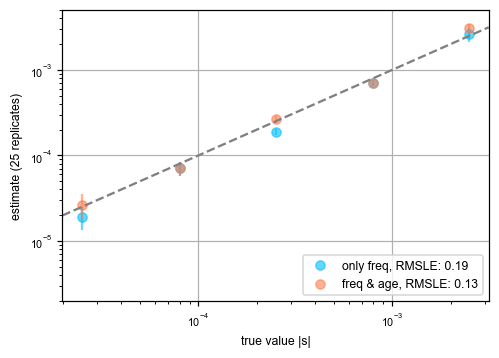

In [141]:
## plotting truth vs mean + CI estimates 
plt.scatter(trues,estfreq,color='deepskyblue',alpha=0.6,label='only freq, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log(trues)-np.log(estfreq))**2)))); 
plt.scatter(trues,estage,color='coral',alpha=0.6,label='freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log(trues)-np.log(estage))**2)))); plt.legend(loc='lower right')
plt.errorbar(trues,estfreq,yerr=sefreq,color='deepskyblue',ls='none',alpha=0.6); plt.xlabel('true value |s|')
plt.errorbar(trues,estage,yerr=seage,color='coral',ls='none',alpha=0.6); plt.ylabel('estimate (25 replicates)')
plt.loglog(); plt.axline((0,0),(1e-3,1e-3),color='grey',linestyle='--'); plt.grid(); plt.ylim((2e-6,5e-3))

In [ ]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

NameError: name 'densegrid' is not defined

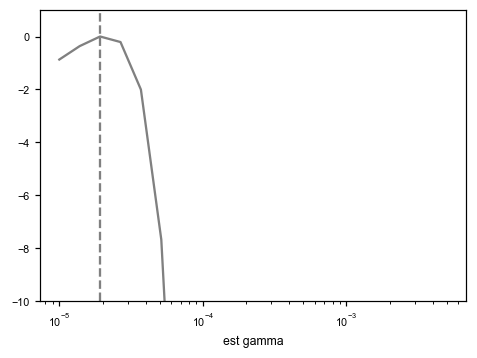

In [ ]:
plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'][0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
# plt.vlines(get_ci(sin_onlyage,gamma),ymin=-10.,ymax=0.,color='k',ls='-.')
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

2. Expansion.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of recent expansion 200 gens ago to 200k inds -> didn't work, too complex a scenario - changing to a simpler 4x expansion...)

In [120]:
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
s = -np.array([2.5e-5,2.5e-4,2.5e-3,8e-5,8e-4]) # gamma of 2, 20, 200 for N=10000 & 4Ns
for ig, g in enumerate(s):
    with open('simfiles/ParameterFilesExpansion.txt',"r") as file:
        data = file.readlines()

    data[2] = 'DFEPointSelectionCoefficient: {:f}\n'.format(-g)
    data[7] = 'FilePrefix: outfiles/Expansion{:.0e}\n'.format(-g)

    with open('simfiles/ParameterFilesExpansion.txt', 'w') as file:
        file.writelines(data)
        
    os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesExpansion.txt 2".format(rng.integers(100496)))

GSL_RNG_TYPE=mrg
GSL_RNG_SEED=43650



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000025
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-05

Demographic History ( 2 epochs )

Ne = 10000	generations = 50000	F = 0.000000
Ne = 40000	generations = 5000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 10000787

Total number of mutations = 13997844


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=83224



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000250
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-04

Demographic History ( 2 epochs )

Ne = 10000	generations = 50000	F = 0.000000
Ne = 40000	generations = 5000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 10002705

Total number of mutations = 14000184


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=48521



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.002500
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion3e-03

Demographic History ( 2 epochs )

Ne = 10000	generations = 50000	F = 0.000000
Ne = 40000	generations = 5000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 10000246

Total number of mutations = 13999045


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=47705



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000080
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion8e-05

Demographic History ( 2 epochs )

Ne = 10000	generations = 50000	F = 0.000000
Ne = 40000	generations = 5000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 10001044

Total number of mutations = 14002807


GSL_RNG_TYPE=mrg
GSL_RNG_SEED=17400



Parameter List

MutationRate: 400.000000
DFEType: point
DFEPointSelectionCoefficient: 0.000800
DemographicHistory: simfiles/Expansion.txt
n: 1000
PrintSegSiteInfo: 1
LastGenerationAFSamplingValue: 1
FilePrefix: outfiles/Expansion8e-04

Demographic History ( 2 epochs )

Ne = 10000	generations = 50000	F = 0.000000
Ne = 40000	generations = 5000	F = 0.000000

Currently in epoch = 0 ; Mutations before epoch's beginning = 0
Currently in epoch = 1 ; Mutations before epoch's beginning = 10002306

Total number of mutations = 14002688


In [123]:
# gamma = -np.logspace(-0.5,2.5,30)
df1 = pd.read_csv("outfiles/Expansion3e-04.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=3000)
Nc = np.concatenate((np.repeat(10000,50000),np.repeat(40000,5000)))
nu_func = lambda t: [Nc[int(t*Nc[0])]/Nc[0]]
df1['sXl'] = df1['Xl']*1000
df1['al'] = len(Nc)+1 - df1['al']
dat = df1.to_numpy(dtype='int64')
# plt.hist(df1['sXl'],10); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],15); plt.xlabel('age of allele'); plt.show()
# plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

In [99]:
## creating a database of P(X, a | s) with dicts for different s values
# del up_xa_s
# up_xa_s = {}
# n = 1000
# for ig, g in enumerate(gamma):
# #     ## unscaled probability - almost likelihood
#     up_xa_s[g] = run_mom_iterate_changing(n, 2*g, Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
#     # up_xa_s[g] = run_mom_iterate_constant(20000, 2000, 0.5*g/Nc[0], N, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

del p_xa_s
p_xa_s = {}
for g in gamma:
    # up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
    # p_xa_s[g] = np.sum(up_xa_s[g], axis=0)
    fs = moments.Spectrum(np.zeros(n+1))
    fs[1] = 1
    fs.integrate(nu_func, 5.49, gamma=g*Nc[0], dt_fac=0.0005, theta=100)
    fs[fs<0] = 1e-250
    p_xa_s[g] = fs/np.sum(fs[np.arange(cutoff,n-cutoff+1)])

N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [4.000]
relative change 3.0


In [138]:
# plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
# plt.plot([nu_func(t) for t in np.linspace(5.49,0,55000)]) # should align on top of real demography if unscaled by Nc[0]
# plt.imshow(up_xa_s[gamma[-1]],aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar()

In [124]:
## inference procedure (plot the loglik surfaces)
sin_onlyfreq = np.empty(len(gamma))
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
    sin_onlyage[ig] = np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))
print(gamma[np.argmax(sin_onlyfreq)]*1e5, gamma[np.argmax(sin_onlyage)]*1e5)
mle = get_boot_ci(gamma,p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=50,cutoff=2)
mle.std(axis=0)*1e5
# plt.plot(mle[:,0],'o',alpha=0.9); plt.plot(mle[:,1],'o',alpha=0.6); plt.axhline(-5e-4,ls='--',color='grey')

-26.333617834718687 -13.690156816728805


array([0.000, 2.378])

10000

In [22]:
# -1412467.660*0.5/2630619535.047, -1958844.339*0.5/8753100490.378
# get_bfq(sin_onlyfreq, gamma)[1]*0.5/get_bfq(sin_onlyfreq, gamma)[0], get_bfq(sin_onlyage, gamma)[1]*0.5/get_bfq(sin_onlyage, gamma)[0]
print(gamma[np.argmax(sin_onlyfreq)], gamma[np.argmax(sin_onlyage)])

-0.005 -0.005


In [470]:
# sin_onlyfreq, gamma*1e5
# -315544.716*0.5/7487071113.44, 1343653.57*0.5/9127767370.694
get_bfq(sin_onlyfreq, gamma), get_bfq(sin_onlyage, gamma)

In [125]:
estfreq, estage = np.array([2.67, 9.87, 26.33, 97.43, 259.9])*1e-5, np.array([1.0, 5.131, 13.69, 70.25, 259.9])*1e-5
sefreq, seage = np.array([4.544, 2., 2.764, 10.44, 47.11])*1e-5, np.array([3.022, 1.62, 3.3, 9.79, 45.15])*1e-5
trues = np.array([1,3.2,10,32,100])*2.5e-5

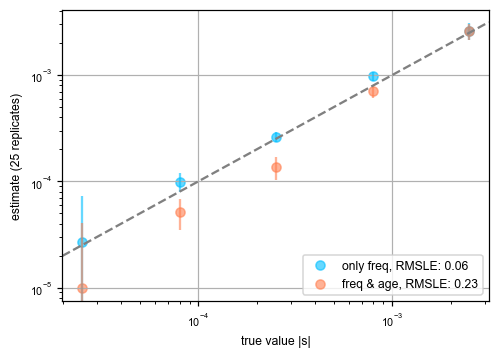

In [126]:
## plotting truth vs mean + CI estimates 
plt.scatter(trues,estfreq,color='deepskyblue',alpha=0.6,label='only freq, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(trues)-np.log10(estfreq))**2)))); 
plt.scatter(trues,estage,color='coral',alpha=0.6,label='freq & age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(trues)-np.log10(estage))**2)))); plt.legend(loc='lower right')
plt.errorbar(trues,estfreq,yerr=sefreq,color='deepskyblue',ls='none',alpha=0.6); plt.xlabel('true value |s|')
plt.errorbar(trues,estage,yerr=seage,color='coral',ls='none',alpha=0.6); plt.ylabel('estimate (25 replicates)')
plt.loglog(); plt.axline((0,0),(1e-3,1e-3),color='grey',linestyle='--'); plt.grid()

-1.0
-1.0


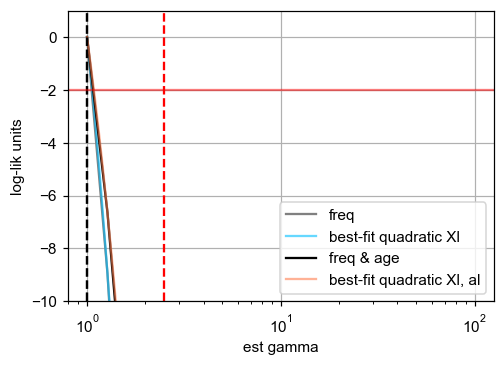

In [ ]:
densegrid = -np.logspace(0,2,base=10,num=100)
lxlbfq = get_bfq(sin_onlyfreq-np.max(sin_onlyfreq), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))
lxlalbfq = get_bfq(sin_onlyage-np.max(sin_onlyage), gamma) @ np.vstack((densegrid**2, densegrid,np.repeat(1.0,100)))

plt.plot(-gamma, sin_onlyfreq-np.max(sin_onlyfreq),'grey', label='freq'); plt.ylim((-10,1)); plt.xlabel('est gamma')
plt.axvline(-gamma[np.argmax(sin_onlyfreq)], color='grey', linestyle='--'); plt.semilogx(); 
plt.plot(-densegrid, lxlbfq-np.max(lxlbfq), color='deepskyblue', alpha=0.6,label='best-fit quadratic Xl');
plt.axvline(df1['s'].iloc[0]*2*Nc[0], color='red', ls='--')
print(gamma[np.argmax(sin_onlyfreq)])
plt.plot(-gamma, sin_onlyage-np.max(sin_onlyage),'k', label='freq & age'); plt.ylim((-10,1)); plt.semilogx()
plt.plot(-densegrid, lxlalbfq-np.max(lxlalbfq), color='coral', alpha=0.6,label='best-fit quadratic Xl, al');
plt.axvline(-gamma[np.argmax(sin_onlyage)], color='k', linestyle='--'); plt.ylabel('log-lik units'); plt.legend(); plt.grid()
print(gamma[np.argmax(sin_onlyage)])
plt.axhline(-2.,color='red',alpha=0.5)

3. BottleneckpExpenasion.txt with point prob selection coefficient () and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, followed by exponential growth)

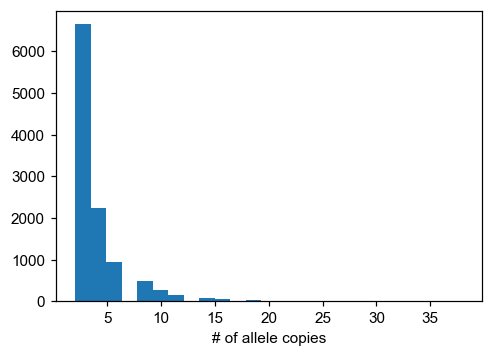

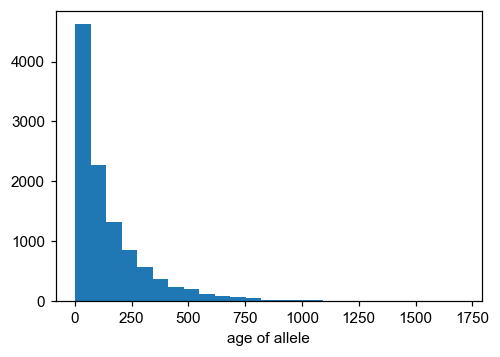

[]

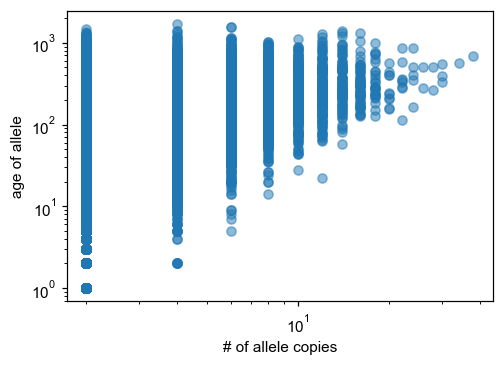

In [ ]:
df1 = pd.read_csv("PReFerSims/outfiles/BottleneckpExpansion10.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
Nc = np.concatenate((np.repeat(10000,50000),np.repeat(2000,500),np.repeat(50000,3000)))/2
df1['sXl'] = df1['Xl']*n #rng.binomial(n=n, p=df1['Xl'])
df1['al'] = len(Nc)+1 - df1['al']
df1 
dat = df1.sample(frac=0.9).to_numpy(dtype='int64')
plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
plt.scatter(df1['sXl'], df1['al'], alpha=0.5); plt.xlabel('# of allele copies'); plt.ylabel('age of allele'); plt.loglog()

[]

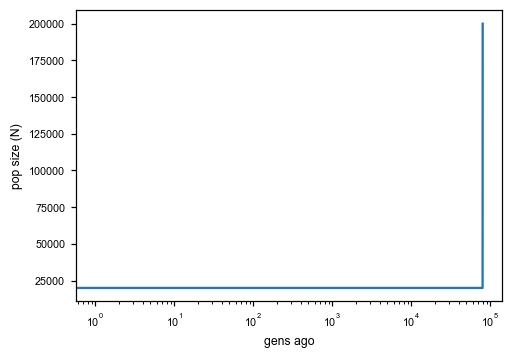

In [ ]:
# up_xa_s = {}
plt.plot(Nc[::-1]); plt.xlabel('gens ago'); plt.ylabel('pop size (N)'); plt.semilogx()
# for ig, g in enumerate(gamma):
#     # unscaled probability - almost likelihood
#     up_xa_s[g] = run_mom_iterate_changing(n, 0.5*g/Nc[0], Nc, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

# p_xa_s = {}
# for g in gamma:
#     up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])
#     p_xa_s[g] = np.sum(up_xa_s[g], axis=0)

In [ ]:
mle = get_boot_ci(gamma[:-1],p_xa_s,up_xa_s,dat,nsamps=len(dat),nboot=50,cutoff=2)
mle.mean(axis=0), mle.std(axis=0)

(array([-249.202, -126.549]), array([0.000, 11.382]))

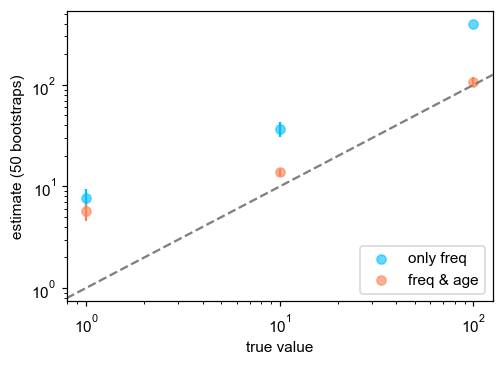

In [ ]:
## plotting truth vs mean + CI estimates 
plt.scatter([1.,10.,100.],[7.69,37.2,400],color='deepskyblue',alpha=0.6,label='only freq')
plt.scatter([1.,10.,100.],[5.69,13.8,107.5],color='coral',alpha=0.6,label='freq & age'); plt.legend(loc='lower right')
plt.errorbar([1.,10.,100.],[7.69,37.2,400],yerr=[1.7,6.2,0],color='deepskyblue',ls='none'); plt.xlabel('true value')
plt.errorbar([1.,10.,100.],[5.69,13.8,107.5],yerr=[1.1,1.1,12.8],color='coral',ls='none'); plt.ylabel('estimate (50 bootstraps)')
plt.loglog(); plt.axline((1,1),(100,100),color='grey',linestyle='--')

### Changing demographic history (Tennessen et al 2012) with Boyko DFE parameters
DFE: $\text{Beta}(\alpha=0.2,\beta=200)$

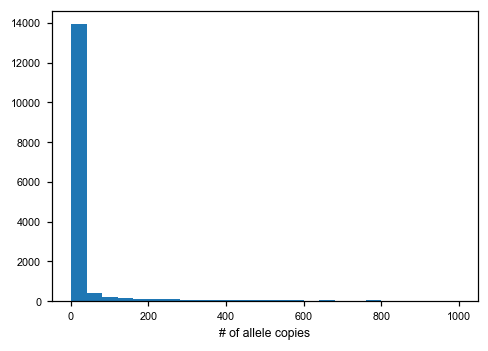

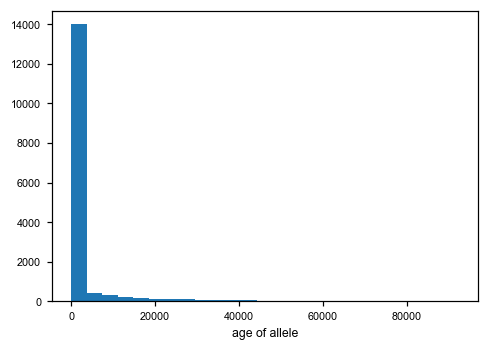

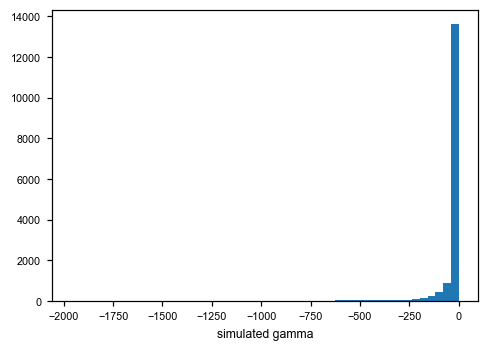

In [4]:
## reading in simulated data + exploratory analysis
df1 = pd.read_csv("outfiles/gammaHuber17.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = df1['Xl']*1000
df1['al'] = 92516 +1 - df1['al']
# df1 = df1.loc[df1['al']<50000,:]
dat = df1.to_numpy(dtype='int64')
plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*24757
plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');
dat = df1.astype('int').to_numpy()

Text(0, 0.5, 'proportion of sites')

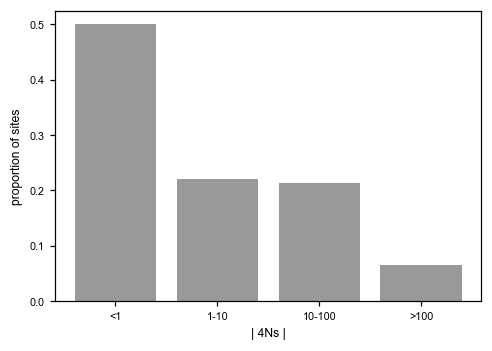

In [8]:
## get simulated distribution of gamma (bins: <1, 1-10, 10-100, >100)
plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.8)
plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel('|4Ns|'); plt.ylabel('proportion of sites')

[]

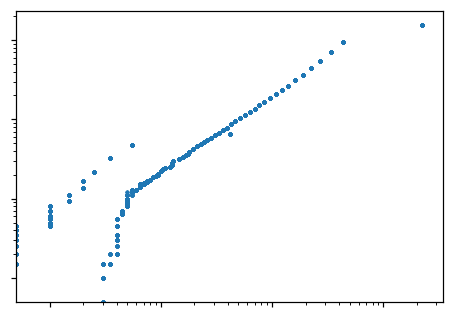

In [168]:
# my_cmap = copy(cm.get_cmap('viridis'))
# my_cmap.set_bad(my_cmap.colors[0])
# Nc = np.linspace(10000,12000,250,dtype='int')
# temp = run_mom_iterate_changing(1000, gamma[-1], Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# temp = run_mom_iterate_constant(len(Nc), 1000, gamma[-1]*0.5/Nc[0], 15000, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# plt.imshow(up_xa_s[gamma[-1]],aspect='auto',interpolation='nearest',norm=colors.LogNorm(vmin=1e-10),cmap=my_cmap); plt.colorbar()
# plt.scatter(np.ravel(up_xa_s[gamma[-5]])[:100000],np.ravel(up_xa_s[gamma[-4]])[:100000], alpha=0.4, s=2); plt.loglog()

In [127]:
# nu_func = lambda t: [Nc[int(t*24757)]/Nc[0]] # Nc[0] = N = 12378
# grdsz = 3
# alpha, beta = np.geomspace(0.1,0.3,grdsz), np.linspace(100,1000,grdsz)
gamma = -np.geomspace(1e-5,5e-2,20)
# dx = ((gamma - np.concatenate(([gamma[0]], gamma))[:-1]) / 2 + (np.concatenate((gamma, [gamma[-1]]))[1:] - gamma) / 2)
# weight = sp.stats.gamma.pdf(gamma, alpha, scale=beta)

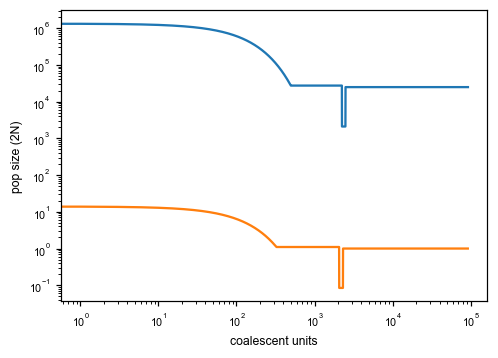

In [133]:
demo = np.loadtxt("simfiles/1kg_1.5_n10_prefersim_demo.txt", delimiter=" ", dtype='int')
Nc = []
[Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
Nc = np.array(list(it.chain(*Nc)))
plt.plot(Nc[::-1]); plt.loglog(); plt.xlabel('gens ago'); plt.ylabel('pop size (2N)');
plt.plot([nu_func(t) for t in np.linspace(3.73,0,92200)]); plt.loglog(); plt.xlabel('coalescent units'); plt.ylabel('pop size (2N)');

In [132]:
# gamma, dx
# fs = moments.Spectrum(np.zeros(1000+1))
# fs[1] = 1
# fs.integrate(nu_func, 3.73, gamma=-gamma[10], dt_fac=0.01, theta=1)
# fs[fs<0] = 1e-250
# moments.Plotting.plot_1d_fs(p_xa_s[gamma[-3]])

array([10000, 10008, 10016, 10024, 10032, 10040, 10048, 10056, 10064,
       10072, 10080, 10088, 10096, 10104, 10112, 10120, 10128, 10136,
       10144, 10152, 10160, 10168, 10176, 10184, 10192, 10200, 10208,
       10216, 10224, 10232, 10240, 10248, 10257, 10265, 10273, 10281,
       10289, 10297, 10305, 10313, 10321, 10329, 10337, 10345, 10353,
       10361, 10369, 10377, 10385, 10393, 10401, 10409, 10417, 10425,
       10433, 10441, 10449, 10457, 10465, 10473, 10481, 10489, 10497,
       10506, 10514, 10522, 10530, 10538, 10546, 10554, 10562, 10570,
       10578, 10586, 10594, 10602, 10610, 10618, 10626, 10634, 10642,
       10650, 10658, 10666, 10674, 10682, 10690, 10698, 10706, 10714,
       10722, 10730, 10738, 10746, 10755, 10763, 10771, 10779, 10787,
       10795, 10803, 10811, 10819, 10827, 10835, 10843, 10851, 10859,
       10867, 10875, 10883, 10891, 10899, 10907, 10915, 10923, 10931,
       10939, 10947, 10955, 10963, 10971, 10979, 10987, 10995, 11004,
       11012, 11020,

In [134]:
## creating a database of P(X, a | s) with dicts for different s values
n = 1000
cutoff = 2
del up_xa_s
up_xa_s = {}
for ig, g in enumerate(gamma):
    up_xa_s[g] = run_mom_iterate_changing(1000, 2*g, Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})

del p_xa_s
p_xa_s = {}
for g in gamma:
    up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)] = up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)]/np.sum(up_xa_s[g][:,np.arange(cutoff,n-cutoff+1)])

    fs = moments.Spectrum(np.zeros(n+1))
    fs[1] = 1
    fs.integrate(nu_func, 3.73, gamma=g, dt_fac=0.0005, theta=100)
    fs[fs<0] = 1e-250
    p_xa_s[g] = fs/np.sum(fs[np.arange(cutoff,n-cutoff+1)])

N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.085]
relative change 0.9152966837662075
N_old,  [0.085] N_new [1.101]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.085]
relative change 0.9152966837662075
N_old,  [0.085] N_new [1.101]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.085]
relative change 0.9152966837662075
N_old,  [0.085] N_new [1.101]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.085]
relative change 0.9152966837662075
N_old,  [0.085] N_new [1.101]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.085]
relative change 0.9152966837662075
N_old,  [0.085] N_new [1.101]
relative change 11.994754411063424
N_old,  [1.000] N_new [1.000]
relative change 0.0
N_old,  [1.000] N_new [0.085]
relative change 0.91

In [154]:
## inference procedure for gamma, but only point DFE (does this work first?)
nsims = 3
mlefreq, mleage = [], []
for n in range(nsims):
    os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=3000)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = 92516 +1 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*24757
    dat = df1.astype('int').to_numpy()

    dub_onlyfreq, dub_onlyage = np.zeros((len(gamma))), np.zeros((len(gamma))) 
    for ig, g in enumerate(gamma):
        dub_onlyfreq[ig] += np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
        dub_onlyage[ig] += np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))

    mlefreq.append(np.argmax(dub_onlyfreq))
    mleage.append(np.argmax(dub_onlyage))

In [155]:
gamma[mlefreq]*1e5, gamma[mleage]*1e5, -0.0125*1e5

(array([-5000.000, -5000.000, -5000.000]),
 array([-2039.881, -2039.881, -2039.881]),
 -1250.0)

In [157]:
## inference procedure basically means integrating over different values of alpha & beta producing a certain gamma using the appropriate prior (Gamma dist)
alpha, beta = np.linspace(0.1,0.3,20), np.linspace(100,1000,20)
nsims = 3
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=5000)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = 92516 +1 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*24757
    dat = df1.astype('int').to_numpy()

    dub_onlyfreq, dub_onlyage = np.zeros((len(alpha),len(beta))), np.zeros((len(alpha),len(beta))) 
    for ia, a in enumerate(alpha):
        for ib, b in enumerate(beta):
            wt = sp.stats.gamma.logpdf(gamma,a,scale=b)
            for g, w in zip(gamma[:-1], wt):
                dub_onlyfreq[ia, ib] += np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=1)) + w
                dub_onlyage[ia, ib] += np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2)) + w

    mlefreq.append(np.unravel_index(np.argmax(dub_onlyfreq,axis=None),dub_onlyfreq.shape))
    mleage.append(np.unravel_index(np.argmax(dub_onlyage,axis=None),dub_onlyage.shape))

In [158]:
mlefreq, mleage

([(0, 0), (0, 0), (0, 0)], [(0, 0), (0, 0), (0, 0)])

In [81]:
## inference procedure using CDF instead of PDF (following Ortega-Del Vecchyo et al 2022 procedure)
alpha, beta = np.linspace(0.1,0.3,20), np.linspace(100,1000,20)
nsims = 5
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=1500)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = 92516 +1 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*24757
    dat = df1.astype('int').to_numpy()

    dub_onlyfreq, dub_onlyage = np.zeros((len(alpha),len(beta))), np.zeros((len(alpha),len(beta)))
    tau = -150 
    for ia, a in enumerate(alpha):
        for ib, b in enumerate(beta):
            wt = np.log([sp.stats.gamma.cdf(g+0.5,a,scale=b)-sp.stats.gamma.cdf(g-0.5,a,scale=b) if g>tau else 1-sp.stats.gamma.cdf(tau-0.5,a,scale=b) for g in gamma])
            for g, w in zip(gamma[:-1], wt):
                dub_onlyfreq[ia, ib] += np.ma.masked_invalid(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=1)+ w).sum()
                # dub_onlyage[ia, ib] += np.ma.masked_invalid(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2) + w).sum()

    mlefreq.append(np.unravel_index(np.argmax(dub_onlyfreq,axis=None),dub_onlyfreq.shape))
    mleage.append(np.unravel_index(np.argmax(dub_onlyage,axis=None),dub_onlyage.shape))